# Finding Colour Objects at PiWars

These are notes about attempting the Computer Vision (CV) for [Eco-Disaster](https://piwars.org/2020-competition/challenges/eco-disaster/) (Sort the Barrels) challenge for PiWars 2020.
I am not competiting in the competition this year so why am I looking at this? There was some chatter on Twitter about creating a "CVZero" library to help contestants with a simplified Computer Vision  library. Secondly, I saw Brian Starkey's [Computer Vision presentation](https://piwarsmc.org/programme.html#brians) at PiWars Mini Conference on what he had done last year without using a recognised CV library. So I attended the CVzero hackathon to see if I could help and learn some things along the way.
After experimenting with different options and colour spaces, the experimentations below looks to use the numpy library to try to capture the red, green, blue, yellow objects of the Eco-Disaster challenge.

The general guidance is to not work in the RGB colour space because the RGB values for a colour (as shown in the image below) change dramatically depending on the lighting conditions. 

![title](img/red_light.png)
![title](img/red_dark.png)

Looking at the relationship between the R, G, and B values, the ratios stay fairly static. This is also true for the different colours used in Eco-disaster when exposed to different levels of light:
![title](img/green_light.png)
![title](img/green_dark.png)
![title](img/blue_light.png)
![title](img/blue_dark.png)
![title](img/yellow_light.png)
![title](img/yellow_dark.png)

In [1]:
import imageio
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
# the `scikit-image` package
import skimage.color
import scipy.ndimage
import skimage.filters

In [2]:
data_actual = os.path.join(os.getenv("TEST_DATA"), 'actual', 'scene*_160_120.jpg')
data_cgi = os.path.join(os.getenv("TEST_DATA"), 'cgi', 'my*.jpg')

In [3]:
files = sorted(glob(data_actual))
images = []
for file in files:
    images.append(imageio.imread(file))

In [4]:
def blur_img(img):
    return scipy.ndimage.gaussian_filter(img, 2)
    fimg = scipy.ndimage.gaussian_filter(img, 3)
    fimgf = scipy.ndimage.gaussian_filter(fimg, 1)
    alpha = 30
    img_s = fimg + alpha * (fimg - fimgf)
    return img_s

def get_red(img):
    return img[:,:,0]

def get_green(img):
    return img[:,:,1]

def get_blue(img):
    return img[:,:,2]

def red_mask(red_lay, green_lay, blue_lay):
    # print('Red mask')
    test1 = red_lay > 160
    if np.any(test1):
        test1 = np.less(np.clip(green_lay.astype('uint16') * 2, 0, 255), red_lay)
        test2 = np.less(np.clip(blue_lay.astype('uint16') * 2, 0, 255), red_lay)
        mask_red = test1 & test2
    else:
        mask_red = np.zeros(red_lay.shape, dtype='bool')
    return skimage.util.invert(mask_red)

def blue_mask(red_lay, green_lay, blue_lay):
    # print('Blue mask')
    test1 = blue_lay > 100
    if np.any(test1):
        blue_lay[blue_lay==0] = 1
        green_lay[green_lay==0] = 1
        test2 = (green_lay / blue_lay) < 0.9
        test3 = (red_lay / green_lay) < 0.8
        mask_blue = test1 & test2 & test3
    else:
        mask_blue = np.zeros(blue_lay.shape, dtype='bool')
    return skimage.util.invert(mask_blue)

def green_mask(red_lay, green_lay, blue_lay):
    # print('Green mask')
    test1 = green_lay > 80
    if np.any(test1):
        green_lay[green_lay==0] = 1
        test2 = (red_lay / green_lay) < 0.9
        test3 = (blue_lay / green_lay) < 0.6
        mask_green = test1 & test2 & test3
    else:
        mask_green = np.zeros(green_lay.shape, dtype='bool')
    return skimage.util.invert(mask_green)

def yellow_mask(red_lay, green_lay, blue_lay):
    # print('Yellow Mask')
    test1 = (red_lay > 120) & (green_lay > 120)
    if np.any(test1):
        red_lay[red_lay==0] = 1
        test2 = (blue_lay / red_lay) < 0.6
        mask_yellow = test1 & test2
    else:
        mask_yellow = np.zeros(red_lay.shape, dtype='bool')
    return skimage.util.invert(mask_yellow)
    

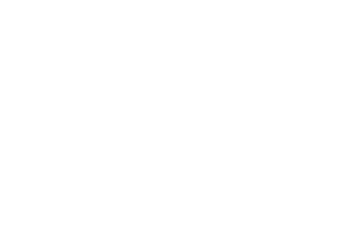

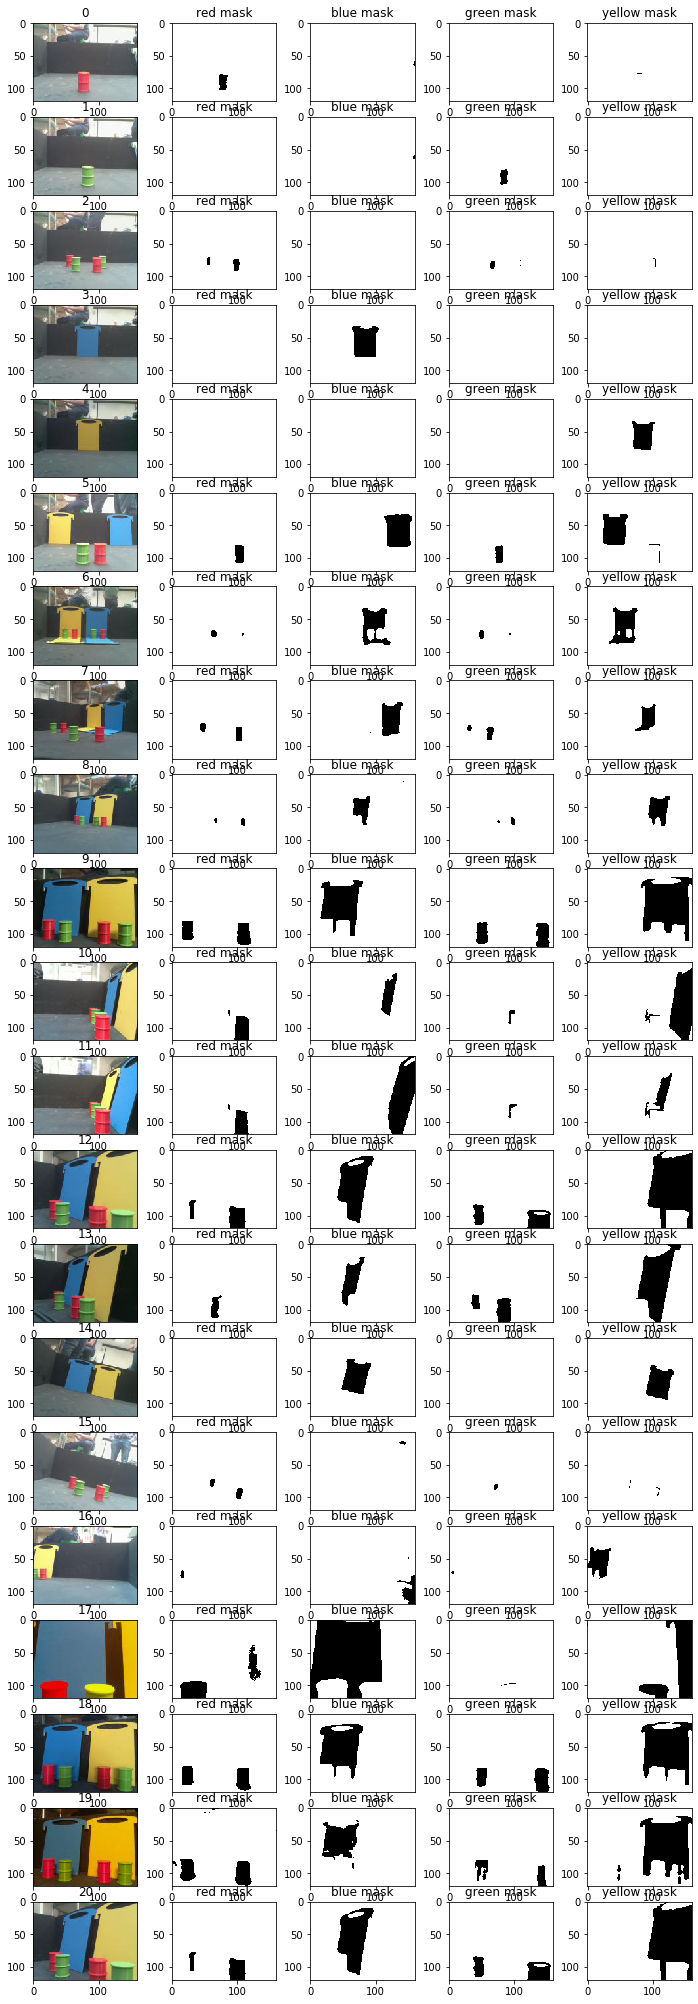

In [5]:
plt.axis('off')
f, ax = plt.subplots(len(images), 5, figsize=(12,36))
for row, this_img in enumerate(images):
    red_c = blur_img(get_red(this_img))
    green_c = blur_img(get_green(this_img))
    blue_c = blur_img(get_blue(this_img))
    # print('row=', row, red_c[80, 180], green_c[80, 180], blue_c[80, 180])
    rm = red_mask(red_c, green_c, blue_c)
    bm = blue_mask(red_c, green_c, blue_c)
    gm = green_mask(red_c, green_c, blue_c)
    ym = yellow_mask(red_c, green_c, blue_c)
    ax[row][0].imshow(this_img)
    ax[row][0].set_title(row)
    ax[row][1].imshow(rm, cmap='gray', vmin=0,vmax=1)
    ax[row][1].set_title('red mask')
    ax[row][2].imshow(bm, cmap='gray', vmin=0,vmax=1)
    ax[row][2].set_title('blue mask')
    ax[row][3].imshow(gm, cmap='gray', vmin=0,vmax=1)
    ax[row][3].set_title('green mask')
    ax[row][4].imshow(ym, cmap='gray', vmin=0,vmax=1)
    ax[row][4].set_title('yellow mask')

plt.show()

cvzero img unique [  0 255]
red labels [0 1 2]
red features 2
red Centre of Mass [(94.69623059866963, 23.379157427937916), (99.74691358024691, 108.24845679012346)]
yellow labels [0 1]
yellow features 1
yellow Centre of Mass [(53.13689974726201, 121.64005897219882)]


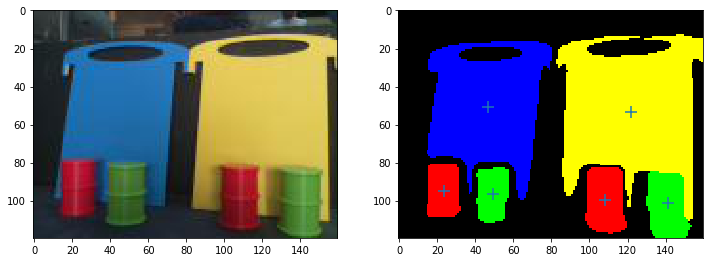

In [6]:
centre_file = os.path.join(os.getenv("TEST_DATA"), 'actual', 'scene19_160_120.jpg')
single_img = imageio.imread(centre_file)
def process_image(this_img):
    red_c = blur_img(get_red(this_img))
    green_c = blur_img(get_green(this_img))
    blue_c = blur_img(get_blue(this_img))
    rm = red_mask(red_c, green_c, blue_c)
    bm = blue_mask(red_c, green_c, blue_c)
    gm = green_mask(red_c, green_c, blue_c)
    ym = yellow_mask(red_c, green_c, blue_c)
    return rm, bm, gm, ym

redm, bluem, greenm, yellowm = process_image(single_img)
cvzero_img = np.zeros(single_img.shape, dtype=int)
cvzero_img[redm==False] = [255, 0, 0]
cvzero_img[greenm==False] = [0, 255, 0]
cvzero_img[yellowm==False] = [255, 255, 0]
cvzero_img[bluem==False] = [0, 0, 255]
red_lbl, red_features = scipy.ndimage.label(np.invert(redm))
red_com = scipy.ndimage.center_of_mass(np.invert(redm), red_lbl, list(range(1, red_features+1)))
yel_lbl, yel_features = scipy.ndimage.label(np.invert(yellowm))
yel_com = scipy.ndimage.center_of_mass(np.invert(yellowm), yel_lbl, list(range(1, yel_features+1)))
blue_lbl, blue_features = scipy.ndimage.label(np.invert(bluem))
blue_com = scipy.ndimage.center_of_mass(np.invert(bluem), blue_lbl, list(range(1, blue_features+1)))
grn_lbl, grn_features = scipy.ndimage.label(np.invert(greenm))
grn_com = scipy.ndimage.center_of_mass(np.invert(greenm), grn_lbl, list(range(1, grn_features+1)))
print('cvzero img unique', np.unique(cvzero_img))
print('red labels', np.unique(red_lbl))
print('red features', red_features)
print('red Centre of Mass', red_com)
print('yellow labels', np.unique(yel_lbl))
print('yellow features', yel_features)
print('yellow Centre of Mass', yel_com)
f, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(single_img)
ax[1].imshow(cvzero_img)
for this_com in [red_com, grn_com, blue_com, yel_com]:
    for this_loc in range(len(this_com)):
        ax[1].scatter(this_com[this_loc][1], this_com[this_loc][0], s=160, c='C0', marker='+')
plt.show()